In [1]:
import os
import json
import time
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pose_visualisation as vis
import reader, helpers
import torch, torch.nn
import scipy
%matplotlib inline
torch.set_default_dtype(torch.double)

import functools
import scipy.io
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam
from torch.utils.data import DataLoader
import math
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
device ='cpu'
import numpy as np
import torch
from torch.autograd.functional import jacobian, hessian
torch.set_default_dtype(torch.double)
from ipynb.fs.defs.gBAOAB import gBAOAB_integrator, gBAOAB_integrator_mass, gBAOAB_step_exact, rattle_step,gBAOAB_integrator_old,gBAOAB_integrator_v
from ipywidgets import IntProgress
from IPython.display import display
import time
import random

In [2]:
def camera_generator(u, consts):
    """Generate camera parameters from (log-)normal model."""
    if u.dim() ==1:
        u = u.unsqueeze(0).detach()
    cam_foc = torch.ones_like(u[:, 0]) * consts['cam_foc']
    cam_pos = torch.concatenate([
        consts['cam_pos_x_mean'] + consts['cam_pos_x_std'] * u[:, 0:1],
        consts['cam_pos_y_mean'] + consts['cam_pos_y_std'] * u[:, 1:2],
        torch.exp(consts['log_cam_pos_z_mean'] +
               consts['log_cam_pos_z_std'] * u[:, 2:3])
    ], 1)
    cam_ang = torch.ones_like(u[:, :3]) * consts['cam_ang']
    return cam_foc, cam_pos, cam_ang

In [3]:
def camera_matrix_batch(focal_length, position, yaw_pitch_roll):
    """Get projective camera matrix given pose and focal length (batch)."""
    if position.ndim == 2:
        n_batch = position.shape[0]
    else:
        n_batch = 1
        focal_length = focal_length.reshape((1,))
        position = position[None, :]
        yaw_pitch_roll = yaw_pitch_roll[None, :]
    cam_mtx = torch.zeros((n_batch, 3, 4))
    rot_mtx = rot_z_batch(yaw_pitch_roll[:, 2])
    rot_mtx = torch.bmm(
        rot_mtx, rot_x_batch(yaw_pitch_roll[:, 1]))
    rot_mtx = torch.bmm(
        rot_mtx, rot_y_batch(yaw_pitch_roll[:, 0]))
    cam_mtx[:, :, :3]= rot_mtx
    cam_mtx[:, :, 3]= position
    int_mtx = torch.stack([focal_length, focal_length,
                        torch.ones_like(focal_length)])
    cam_mtx = (int_mtx * cam_mtx.T).T
    return cam_mtx


In [4]:
def rot_x(ang):
    """Returns matrix which defines rotation by `ang` about x-axis (0-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        1, 0, 0,
        0, c, -s,
        0, s, c,
    ]).reshape((3, 3))


def rot_y(ang):
    """Returns matrix which defines rotation by `ang` about y-axis (1-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, 0, s,
        0, 1, 0,
        -s, 0, c,
    ]).reshape((3, 3))


def rot_z(ang):
    """Returns matrix which defines rotation by `ang` about z-axis (2-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, -s, 0,
        s, c, 0,
        0, 0, 1,
    ]).reshape((3, 3))


def rot_x_batch(ang):
    """Returns batch of matrices which defines rotations about x-axis (0)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 1, 1]=c
    rot[:, 1, 2]= -s
    rot[:, 2, 1]= s
    rot[:, 2, 2]= c
    return rot


def rot_y_batch(ang):
    """Returns batch of matrices which defines rotations about y-axis (1)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 2]= s
    rot[:, 2, 0]= -s
    rot[:, 2, 2]= c
    return rot


def rot_z_batch(ang):
    """Returns batch of matrices which defines rotations about z-axis (2)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 1]= -s
    rot[:, 1, 0]=s
    rot[:, 1, 1]=c
    return rot


rotation_map = {
    'Xrotation': rot_x,
    'Yrotation': rot_y,
    'Zrotation': rot_z
}
rotation_map_batch = {
    'Xrotation': rot_x_batch,
    'Yrotation': rot_y_batch,
    'Zrotation': rot_z_batch
}

In [5]:
consts = {
    'seed': 1234,
    'n_joint': 19,
    'n_joint_angle': 47,
    'n_joint_angle_latent': 30,
    'n_bone_length_input': 13,
    'n_camera_input': 3,
    'output_noise_std': 0.001,
    'cam_foc': np.exp(2.),
    'cam_pos_x_mean': 0.,
    'cam_pos_y_mean': 0.,
    'cam_pos_x_std': 0.1,
    'cam_pos_y_std': 0.1,
    'log_cam_pos_z_mean': 1.5,
    'log_cam_pos_z_std': 0.5,
    'cam_ang': torch.tensor(np.array([np.pi, 0., 0.])),
    'cam_pos_offset': torch.tensor(np.array([0.5, 0., 0.])),
    'cam_ang_offset': torch.tensor(np.array([0.0, 0., 0.]))
}
consts['n_joint_angle_input'] = (
    consts['n_joint_angle_latent'] +
    consts['n_joint_angle'] * 2)

In [6]:
bvh_reader = reader.BvhReader('skeleton.bvh')
bvh_reader.read()
helpers.process_skeleton(bvh_reader.root)
consts['skeleton'] = bvh_reader.root

with open('fixed_angles.json', 'r') as f:
    consts['fixed_joint_angles'] = json.load(f)

In [7]:
with np.load('params.npz') as f:
    l = 1
    #print(f['W_{0}'.format(l)])
    print('W_{0}'.format(l))

W_1


In [8]:
with np.load('params.npz') as f:
    num_layers = 7
    consts['joint_angles_vae_decoder_layers'] = []
    for l in range(num_layers):
        weight = torch.tensor(f['W_{0}'.format(l)])
        bias = torch.tensor(f['b_{0}'.format(l)])

        linear_layer = torch.nn.Linear(weight.size(0), weight.size(1))
        linear_layer.weight.data = weight
        linear_layer.bias.data = bias
        if l != num_layers - 1:
            nonlinearity = torch.nn.Tanh()
        else:
            nonlinearity = torch.nn.Identity()
        consts['joint_angles_vae_decoder_layers'].append({
            'linear_layer': linear_layer,
            'nonlinearity': nonlinearity })

In [9]:
consts['joints_to_skip'] = [
    'hips',
    'leftshoulder',
    'rightshoulder',
    'lefthandthumb1',
    'righthandthumb1',
    'lefthandthumb1endsite',
    'righthandthumb1endsite',
    'lefttoebaseendsite',
    'righttoebaseendsite'
]
lengths_model_params = np.load('params2.npz')
consts['log_lengths_covar'] = torch.tensor(lengths_model_params['covar'])
consts['log_lengths_covar_chol'] = torch.tensor(la.cholesky(lengths_model_params['covar']))
consts['log_lengths_mean'] = torch.tensor(lengths_model_params['mean'])

In [10]:
with open('lengths_order.json', 'r') as f:
    lengths_order = json.load(f)
    consts['bone_lengths_map'] = {
    node_name: lengths_order[length_name]
    for node_name, length_name
    in helpers.bone_lengths_map.items()
    if node_name not in ['lefthandthumb1endsite', 'righthandthumb1endsite']
}

In [11]:
rng = np.random.RandomState(consts['seed'])

In [12]:
n_noise = consts['n_joint'] * 4
n_in_dim = (
    consts['n_camera_input'] +
    consts['n_bone_length_input'] +
    consts['n_joint_angle_input'] +
    4 * consts['n_joint']
)

In [13]:
# this bit does some weird thing where it pre-calls the function, nothing is actually being generated yet since u is just some constant
# u = tt.matrix('u')
# y_bin = pose.noisy_binocular_2d_proj_generator(u, consts)
# y_3d = pose.joint_3d_pos_generator(u, consts)
# generator_binocular = th.function([u], y_bin)
# generator_3d = th.function([u], y_3d)

In [14]:
def partition(inputs, lengths):
    """Partition a one/two-dimesional tensor in to parts along last axis."""
    i = 0
    parts = []
    for l in lengths:
        parts.append(inputs.T[i:i+l].T)
        i += l
    return parts

In [15]:
def bone_lengths_generator(u, consts):
    """Generate skeleton bone lengths from log-normal model."""
    rng.seed(0)
    u_data = torch.tensor(rng.normal(size=u.size()))
    return torch.exp(consts['log_lengths_mean'] +
                  (u_data @ consts['log_lengths_covar_chol']))

def joint_angles_cos_sin_vae_decoder(h, layers, n_joint_angle):
    h = layers[0]['nonlinearity'](
        (h @ layers[0]['linear_layer'].weight.data) + layers[0]['linear_layer'].bias.data)
    # intermediate layers with skip-connections
    for layer in layers[1:-1]:
        h = layer['nonlinearity'](
            (h@layer['linear_layer'].weight.data) + layer['linear_layer'].bias.data) + h
    h = layers[-1]['nonlinearity'](
    (h@layers[-1]['linear_layer'].weight.data) + layers[-1]['linear_layer'].bias.data)
    print(h.size())
    if h.dim() == 1:
        h =h.unsqueeze(0).detach()
    print(h.size())
    return h[:, :n_joint_angle * 2], torch.exp(0.5 * h[:, n_joint_angle * 2:])


def joint_angles_generator(u, consts):
    """Generate joint angles from VAE decoder model."""
    h, n = partition(u, [consts['n_joint_angle_latent'],
                         consts['n_joint_angle'] * 2])
    ang_cos_sin_mean, ang_cos_sin_std = joint_angles_cos_sin_vae_decoder(
        h, consts['joint_angles_vae_decoder_layers'], consts['n_joint_angle'])
    ang_cos_sin = ang_cos_sin_mean + ang_cos_sin_std * n
    return torch.arctan2(ang_cos_sin[:, consts['n_joint_angle']:],
                      ang_cos_sin[:, :consts['n_joint_angle']])

In [16]:
def joint_positions(node, angles, fixed_angles=None, lengths=None,
                    lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles."""
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4)
    joints = []
    rot = torch.eye(3)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = (rot@rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = (rot@ rotation_map[ch](torch.tensor(angles[i[0]])))
                i[0] += 1
    local_trans = torch.eye(4)
    local_trans[:3, :3] = rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = torch.tensor(np.array(node.offset))
        else:
            length = lengths[lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit) * length)
        local_trans[:3, 3] = torhc.tensor(node_offset)
        node_trans = parent_trans.dot(local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, 3])
        for child in node.children:
            joints += joint_positions(child, angles, fixed_angles, lengths,
                                      lengths_map, skip, i, node_trans)
    return joints

In [17]:
def joint_positions_batch(
        node, angles, fixed_angles=None, lengths=None,
        lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles (batch)."""
    # check whether single vector of angles or mini-batch matrix provided
    if angles.ndim == 2:
        n_batch = angles.shape[0]
    elif angles.ndim == 1:
        n_batch = 1
        angles = angles[None, :]
        if lengths is not None and lengths.ndim == 1:
            lengths = lengths[None, :]
    else:
        raise Exception('angles should be one or two dimensional.')
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    joints = []
    rot = torch.eye(3).unsqueeze(0).repeat(n_batch, 1, 1)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = rot@(rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = torch.bmm(
                    rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
                i[0] += 1
    local_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    local_trans[:, :3, :3] =  rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = np.array(node.offset)[None, :]
        else:
            if lengths.dim() == 1:
                lengths = lengths.unsqueeze(0).detach()
            length = lengths[:, lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit[None, :]) *
                           length[:, None])
        local_trans[:, :3, 3]= torch.tensor(node_offset)
        node_trans = torch.bmm(parent_trans, local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, :, 3])
        for child in node.children:
            joints += joint_positions_batch(
                child, angles, fixed_angles, lengths,
                lengths_map, skip, i, node_trans)
    return joints


In [18]:
def joint_3d_pos_generator(u, consts):
    """Generate 3D joint positions.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system.
    """
    input_sizes = [consts['n_bone_length_input'],
                   consts['n_joint_angle_input']]
    u_len, u_ang = partition(u, input_sizes)
    bone_lengths = bone_lengths_generator(u_len, consts)
    joint_angles = joint_angles_generator(u_ang, consts)
    return torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2)

In [19]:
def binocular_2d_proj_generator(u, consts):
    """Generate binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models.
    """
    n_batch = 1
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'],
                   consts['n_camera_input']]
    u_ske, u_cam, = partition(u, input_sizes)
    joint_pos_3d = joint_3d_pos_generator(u_ske, consts)
    cam_foc, cam_pos, cam_ang = camera_generator(u_cam, consts)
    cam_mtx_1 = camera_matrix_batch(
        cam_foc, cam_pos + consts['cam_pos_offset'],
        cam_ang + consts['cam_ang_offset'])
    cam_mtx_2 = camera_matrix_batch(
        cam_foc, cam_pos - consts['cam_pos_offset'],
        cam_ang - consts['cam_ang_offset'])
    joint_pos_2d_hom_1 = torch.bmm(cam_mtx_1, joint_pos_3d)
    joint_pos_2d_1 = (joint_pos_2d_hom_1[:, :2] /
                      joint_pos_2d_hom_1[:, 2][:, None, :])
    joint_pos_2d_hom_2 = torch.bmm(cam_mtx_2, joint_pos_3d)
    joint_pos_2d_2 = (joint_pos_2d_hom_2[:, :2] /
                      joint_pos_2d_hom_2[:, 2][:, None, :])

    return torch.concatenate(
               [joint_pos_2d_1.reshape((n_batch, -1)),
                joint_pos_2d_2.reshape((n_batch, -1))], 1)



In [20]:
def noisy_binocular_2d_proj_generator(u, consts):
    """Generate noisy binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models and adding Gaussian observation noise to
    projections.
    """
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'] +
                   consts['n_camera_input'],
                   consts['n_joint'] * 4]
    u_pos, u_noi = partition(u, input_sizes)
    return (binocular_2d_proj_generator(u_pos, consts) +
            consts['output_noise_std'] * u_noi)

## "Observed" Data

In [21]:
n_data = 1
rng.seed(consts['seed'])
u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
y_data = noisy_binocular_2d_proj_generator(u_data, consts)
y_data_3d = joint_3d_pos_generator(u_data, consts)
np.savez('observed-data.npz',u_data=u_data, y_data=y_data, y_data_3d=y_data_3d)

torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\959262985.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensi

In [22]:
y_data_3d[:,0:3,:].squeeze().size()

torch.Size([3, 19])

## Generating a ton of these

In [23]:
transform = torch.zeros((19,3))
for i in range(19):
    transform[i][2] = 2
transform = transform.unsqueeze(0)

In [24]:
train_dataset = []
for i in range(100):
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    train_dataset.append(points_3d+ transform - points_3d[0][0])

torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1

In [25]:
train_dataset[0].size()

torch.Size([1, 19, 3])

In [26]:
test_dataset = []
for i in range(1001,1111):
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    print("Points = ",points_3d)
    print("Points = ",points_3d - points_3d[0][0])
    test_dataset.append(points_3d+transform- points_3d[0][0])

torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
torch.Size([1, 188])
Points =  tensor([[[-1.3270e-02,  1.7789e-01,  1.2224e-01],
         [-1.3690e-01,  6.4016e-01,  2.4477e-01],
         [-1.1347e-01,  7.7542e-01,  2.4528e-01],
         [-3.1088e-01,  4.6805e-01,  1.3529e-01],
         [-5.7742e-01,  3.8936e-01, -8.4827e-02],
         [-7.7714e-01,  3.7220e-01, -2.9812e-01],
         [-8.8491e-01,  3.4988e-01, -3.5748e-01],
         [ 1.0497e-01,  5.0664e-01,  3.0511e-01],
         [ 4.2106e-01,  3.6850e-01,  3.8695e-01],
         [ 7.0091e-01,  2.9124e-01,  4.2419e-01],
         [ 8.1429e-01,  2.8793e-01,  4.7684e-01],
         [-1.0894e-01, -8.3998e-03,  3.9718e-04],
         [-1.8767e-01, -4.8427e-01, -2.0399e-01],
         [-2.5871e-01, -9.0985e-01, -3.8943e-01],
         [-3.4853e-01, -8.0020e-01, -5.3085e-01],
         [ 1.0894e-01,  8.3998e-03, -3.9718e-04],
         [ 2.8856e-01,  6.8553e-02, -4.8880e-01],
         [ 3.1709e-01, -3.0401e-01, -7.7330e-01],
      

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


Points =  tensor([[[-0.0065,  0.1691,  0.1346],
         [ 0.1645,  0.6317,  0.1619],
         [ 0.2222,  0.7561,  0.1551],
         [ 0.3253,  0.5270,  0.0979],
         [ 0.4819,  0.2114,  0.0586],
         [ 0.5937, -0.0571,  0.0921],
         [ 0.6218, -0.1707,  0.0482],
         [ 0.0357,  0.6970,  0.1781],
         [-0.2732,  0.7141,  0.3512],
         [-0.5156,  0.7146,  0.5152],
         [-0.6103,  0.7244,  0.5963],
         [ 0.1038, -0.0186,  0.0284],
         [-0.0666, -0.5138,  0.0141],
         [-0.2195, -0.9576,  0.0015],
         [-0.2272, -0.9375,  0.2006],
         [-0.1038,  0.0186, -0.0284],
         [-0.1898, -0.4959,  0.0192],
         [-0.2688, -0.9561,  0.0698],
         [-0.2725, -0.9661,  0.2697]]])
Points =  tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.1710,  0.4626,  0.0273],
         [ 0.2288,  0.5870,  0.0204],
         [ 0.3319,  0.3579, -0.0367],
         [ 0.4884,  0.0423, -0.0760],
         [ 0.6002, -0.2261, -0.0425],
         [ 0.6284, -0.3398, 

In [27]:
train_dataset[4]

tensor([[[ 0.0000,  0.0000,  2.0000],
         [ 0.0723,  0.4876,  1.9681],
         [ 0.0617,  0.6233,  1.9861],
         [ 0.2740,  0.3537,  1.9926],
         [ 0.3412,  0.0065,  2.0184],
         [ 0.2995, -0.2300,  2.1857],
         [ 0.3020, -0.3465,  2.2312],
         [-0.0101,  0.5327,  1.8906],
         [-0.2382,  0.6156,  1.6322],
         [-0.3381,  0.8743,  1.5386],
         [-0.3593,  0.9814,  1.4776],
         [ 0.1034, -0.2191,  1.9990],
         [ 0.1447, -0.7321,  1.9010],
         [ 0.1784, -1.1986,  1.8592],
         [ 0.2161, -1.2604,  2.0459],
         [-0.1112, -0.2112,  1.9584],
         [-0.1109, -0.7260,  1.8612],
         [-0.1227, -1.1939,  1.8234],
         [-0.2377, -1.2253,  1.9842]]])

In [28]:
ts = np.array([td[:,:,2].numpy() for td in test_dataset])

In [29]:
ts.min()

0.8366985058712301

In [30]:
j3d33 = y_data_3d[:,0:3,:].squeeze().T

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

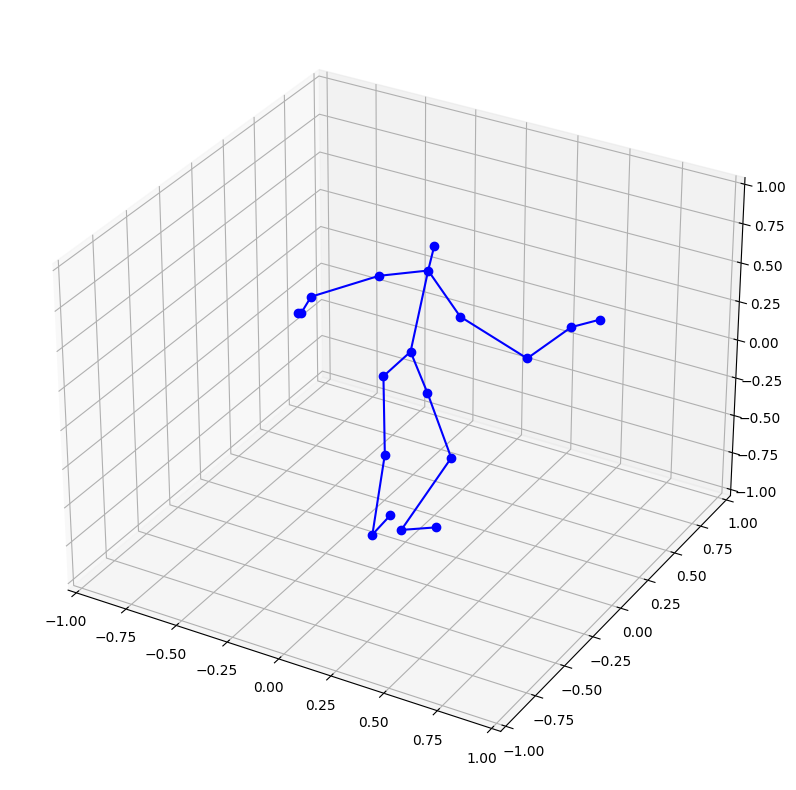

In [31]:
vis.plot_3d_pose(j3d33)

## PCA

In [32]:
train_data = np.array([d.numpy() for d in train_dataset])
test_data = np.array([d.numpy() for d in test_dataset])

In [33]:
list = np.transpose(np.array([data[0].flatten().numpy() for data in train_dataset]))

# Demean each row
mean_row = np.mean(list, axis=1, keepdims=True)
list = list - mean_row

In [34]:
np.shape(list)

(57, 100)

In [35]:
U, S,_=np.linalg.svd(list)

In [36]:
eigenposes = np.transpose(U)
eigenvalues = S**2

In [37]:
ep0=eigenposes[1]

In [38]:
eigenposes[1]

array([ 0.00000000e+00,  0.00000000e+00,  1.66533454e-16,  1.62660870e-02,
        1.32027237e-02, -3.04857691e-02,  1.63951130e-02,  1.54795073e-02,
       -2.40850582e-02,  4.28431941e-02,  5.24160358e-02, -3.09266915e-02,
        7.49536919e-02,  1.07935330e-01,  2.32433812e-02,  7.09425646e-02,
        2.36178951e-01,  1.01452870e-01,  7.89788575e-02,  2.91594243e-01,
        1.33182269e-01, -2.63841184e-02, -6.13566220e-02, -3.63177479e-02,
       -6.36872808e-02, -2.60807589e-01, -2.96208412e-02, -8.77144321e-02,
       -4.23604766e-01,  1.28082679e-02, -9.56134260e-02, -4.89661150e-01,
        3.15030471e-02, -2.63384162e-03,  5.20793458e-03,  3.41347066e-02,
       -4.27506836e-02,  2.56294945e-02,  1.17816582e-01, -8.76941439e-02,
        3.25471736e-02,  1.58488591e-01, -8.31769450e-02,  4.62202280e-02,
        1.89215711e-01, -3.11026202e-02, -9.56674822e-03,  2.60495835e-02,
       -7.88037563e-02,  7.92304078e-02,  1.66885390e-01, -9.82318949e-02,
        1.08707031e-01,  

In [39]:
np.shape(eigenposes[0])

(57,)

In [40]:
np.shape(mean_row)

(57, 1)

In [41]:
eigenposes[0]

array([ 0.00000000e+00,  1.38777878e-17, -1.11022302e-16, -4.79980636e-02,
        3.20627345e-02,  7.22648934e-02, -5.95614098e-02,  4.70552946e-02,
        1.03317275e-01,  6.55706475e-02,  2.16953133e-02,  1.50769445e-02,
        2.11426429e-01,  1.12142711e-02, -4.26820014e-02,  3.11723917e-01,
        2.86437321e-02,  7.33787351e-04,  3.53132216e-01,  4.39327483e-02,
        1.02447912e-02, -1.53042135e-01,  4.05598064e-02,  4.99682317e-02,
       -2.79846302e-01,  6.03147642e-03,  5.08996467e-02, -3.56153415e-01,
       -2.39125574e-02,  1.09215471e-01, -3.88642390e-01, -3.54650077e-02,
        1.32102279e-01,  6.36967014e-02, -2.07961762e-02, -4.55762221e-02,
        1.17237947e-01, -5.99132669e-02, -1.20049543e-01,  1.58148236e-01,
       -8.90140468e-02, -2.05800939e-01,  2.18731259e-01, -1.02886930e-01,
       -1.30596637e-01, -4.86802322e-02, -7.41339059e-03, -3.25836303e-02,
       -5.93670145e-02, -6.05365091e-02, -8.29913057e-02, -5.65492975e-02,
       -8.80942865e-02, -

In [42]:
mean_row

array([[ 0.        ],
       [ 0.        ],
       [ 2.        ],
       [ 0.02592165],
       [ 0.44310383],
       [ 2.03739121],
       [ 0.02822911],
       [ 0.55719369],
       [ 2.04806469],
       [ 0.15324295],
       [ 0.35551076],
       [ 2.01929785],
       [ 0.27002997],
       [ 0.1415388 ],
       [ 2.03428776],
       [ 0.30236764],
       [ 0.04579443],
       [ 2.13781603],
       [ 0.31997431],
       [ 0.01036813],
       [ 2.16789795],
       [-0.09796416],
       [ 0.38265706],
       [ 1.9893266 ],
       [-0.21670072],
       [ 0.24886809],
       [ 1.95686871],
       [-0.27197874],
       [ 0.18064867],
       [ 2.01208064],
       [-0.29501199],
       [ 0.14987672],
       [ 2.0309916 ],
       [ 0.06229087],
       [-0.19513842],
       [ 1.98424282],
       [ 0.047805  ],
       [-0.66816407],
       [ 1.9873188 ],
       [ 0.03973333],
       [-1.0854872 ],
       [ 1.95164105],
       [ 0.05911627],
       [-1.12568175],
       [ 2.06444598],
       [-0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\1731707433.py:17: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


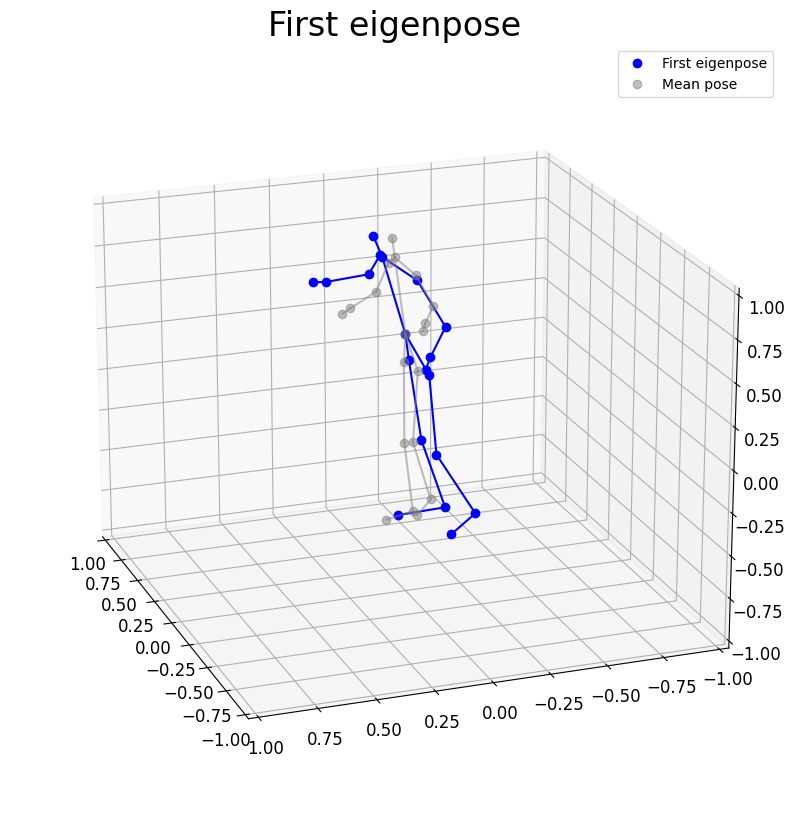

In [60]:
ep0 = (eigenposes[0]  +np.squeeze(mean_row)).reshape((19,3))
ep1 = (np.squeeze(mean_row)).reshape((19,3))
t = np.ones_like(ep0)
t1 = np.ones_like(ep0)
t1[:,1] = np.zeros_like(t1[:,1])
t1[:,2] = np.zeros_like(t1[:,2])
t2 = np.zeros_like(ep0)
t2[:,1] = np.ones_like(t2[:,1])

t3 = np.zeros_like(ep0)
t3[:,2] = np.ones_like(t3[:,1])
fig, ax =vis.add_3d_pose([ep0+t2/2-t3*2, ep1+t2/2-t3* 2], alphas =[1,0.5], labels = ["First eigenpose","Mean pose"])

ax.set_title('First eigenpose', fontsize = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.legend()
ax.view_init(20, 160)
plt.savefig('eigen0.pdf',bbox_inches = 'tight')


In [63]:
for bone in bones:
    b1, b2 = bone
    d = np.sqrt(np.dot(mean_row.reshape((19,3))[b1] - mean_row.reshape((19,3))[b2],mean_row.reshape((19,3))[b1] - mean_row.reshape((19,3))[b2]))
    print(d)

0.4454335429733546
0.11461126736121437
0.15559765463608866
0.2442292001001195
0.14467485099468472
0.04969848879006434
0.145985323692883
0.18180036557805146
0.10372032994755466
0.04283768966306293
0.20544450566498507
0.47325739590448296
0.41892320696875496
0.12131055839323202
0.20562037836912733
0.40144253326738333
0.3770927872682448
0.1091163390863191


In [64]:
for bone in bones:
    b1, b2 = bone
    d = np.sqrt(np.dot(ep0[b1] - ep0[b2],ep0[b1] - ep0[b2]))
    print(d)

0.4881547863005331
0.13597422263687214
0.27072408895881606
0.3481229329436135
0.21287993934706811
0.07386390671084167
0.2450681001032663
0.2993574430678208
0.19959775474928898
0.08137029723558001
0.257414850166328
0.5185683028727047
0.46380785266928587
0.21134169700106198
0.23960835899486457
0.4540365176319402
0.43540613084752816
0.170419800116338


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\2310532694.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


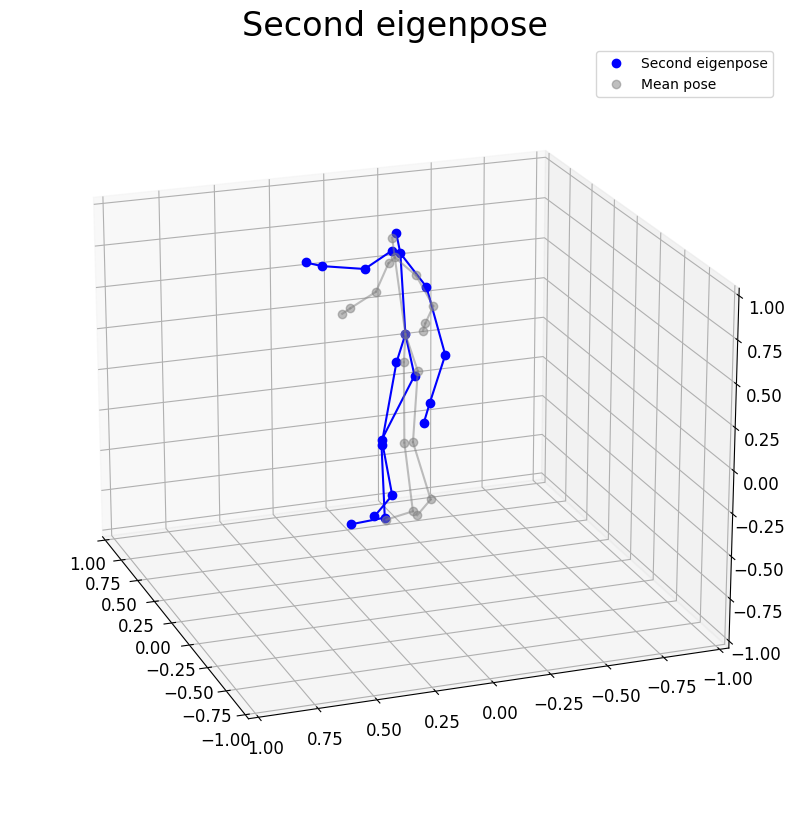

In [61]:
 ep0 = (eigenposes[1]  +np.squeeze(mean_row)).reshape((19,3))
ep1 = (np.squeeze(mean_row)).reshape((19,3))
t3 = np.zeros_like(ep0)
t3[:,2] = np.ones_like(t3[:,1])
fig, ax =vis.add_3d_pose([ep0+t2/2-t3*2, ep1+t2/2-t3* 2], alphas =[1,0.5], labels = ["Second eigenpose","Mean pose"])

ax.set_title('Second eigenpose', fontsize = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.legend()
ax.view_init(20, 160)
plt.savefig('eigen1.pdf',bbox_inches = 'tight')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1444\2921942089.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


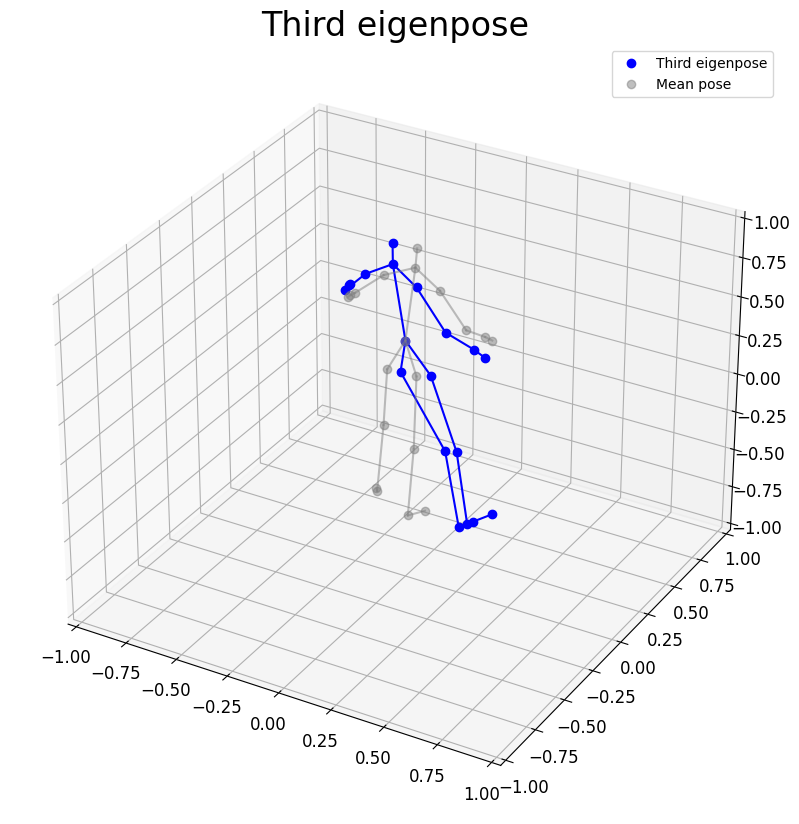

In [59]:

ep0 = (eigenposes[2] + np.squeeze(mean_row)).reshape((19, 3))
ep1 = (np.squeeze(mean_row)).reshape((19, 3))
t3 = np.zeros_like(ep0)
t3[:,2] = np.ones_like(t3[:,1])
fig, ax =vis.add_3d_pose([ep0+t2/2-t3*2, ep1+t2/2-t3* 2], alphas =[1,0.5], labels = ["Third eigenpose","Mean pose"])

ax.set_title('Third eigenpose', fontsize = 24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.legend()
plt.savefig('eigen2.pdf', bbox_inches='tight')

In [42]:
eigenvalues = eigenvalues[:-2]
eigenposes = eigenposes[:-2]

In [43]:
# getting rid of insignificant eigenvalues

In [44]:
# getting the average pose
avg_pose = np.squeeze(train_data.mean(axis=0))
avg_pose = np.ndarray.flatten(avg_pose)
avg_pose.reshape(19, 3)

array([[ 0.        ,  0.        ,  2.        ],
       [ 0.02592165,  0.44310383,  2.03739121],
       [ 0.02822911,  0.55719369,  2.04806469],
       [ 0.15324295,  0.35551076,  2.01929785],
       [ 0.27002997,  0.1415388 ,  2.03428776],
       [ 0.30236764,  0.04579443,  2.13781603],
       [ 0.31997431,  0.01036813,  2.16789795],
       [-0.09796416,  0.38265706,  1.9893266 ],
       [-0.21670072,  0.24886809,  1.95686871],
       [-0.27197874,  0.18064867,  2.01208064],
       [-0.29501199,  0.14987672,  2.0309916 ],
       [ 0.06229087, -0.19513842,  1.98424282],
       [ 0.047805  , -0.66816407,  1.9873188 ],
       [ 0.03973333, -1.0854872 ,  1.95164105],
       [ 0.05911627, -1.12568175,  2.06444598],
       [-0.07100631, -0.19074486,  1.9707726 ],
       [-0.11043842, -0.5886449 ,  2.00650467],
       [-0.09225392, -0.95524124,  1.92004419],
       [-0.14180533, -1.01232772,  1.99873451]])

In [45]:
def length_constraint(i,j, init):
    def constraint_fn(x):
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [46]:
i = 0
j=1

In [47]:
x_init = train_dataset[0]
lengths = []
for n in range(50):
    x = torch.flatten(train_dataset[n][0])
    l = (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2
    lengths.append(l)

In [48]:
def avg_j2j(frame1,frame2):
    dists = []
    frame_1 = np.array(frame1)
    frame_2 = np.array(frame2)
    for i in range(len(frame1)):
        d = math.dist(frame_1[i], frame_2[i])
        dists.append(d)
    return np.mean(dists)

In [49]:
h = .001

In [54]:
# taking the list of bones from pose_visualisation for the constraints
bones = [
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (11, 12),
    (12, 13),
    (13, 14),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [51]:
def length_constraint_2(i, init):
    def constraint_fn(x):
        return (x[3*i]- 0)**2 +(x[3*i+1]- 0)**2 + (x[3*i+2]- 1)**2 - ((init[3*i]- 0)**2 +(init[3*i+1]- 0)**2 + (init[3*i+2]- 1)**2)
    return constraint_fn

In [52]:
def median(positions):
    dist = 1000
    median = positions[0].detach().reshape((19,3))
    for position in positions:
        dis = 0
        for pos2 in positions:
            dis += torch.linalg.norm(position.detach() - pos2.detach())
        if dis< dist:
            dist = dis
            median = position.detach().reshape((19,3))
    return median

In [53]:
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [54]:
init = torch.flatten(x_init)


In [55]:
def force(x):
    return torch.zeros_like(x)

In [56]:
def noising_process(pose,p, its, h):
    gs = [length_constraint(i,j,init) for (i,j) in bones2]
    M = torch.eye(len(pose))
    qs, ps = gBAOAB_integrator(pose,p,force, gs, h,M, 1, 1, its)
    return qs[-1], ps[-1]

In [57]:
q0 = torch.flatten(test_dataset[0])
q1, v1 = noising_process(q0,torch.zeros_like(q0), 1,0.01)

In [58]:
q2,v2 = noising_process(q1,v1,9,0.01)
q3,v3 = noising_process(q2,v2,10,0.01)

In [59]:
q4,v4 = noising_process(q3,v3,80,0.01)

In [60]:
pose0 = q0.reshape((19,3))
pose1 = q1.detach().reshape((19,3))
pose2 = q2.detach().reshape((19,3))
pose3 = q3.detach().reshape((19,3))

In [61]:
pose4 = q4.detach().reshape((19,3))
pose4 = pose4 -pose4[0]+ pose0[0]

In [62]:
pose1 = pose1 -pose1[0]+ pose0[0]
pose2 = pose2 -pose2[0]+ pose0[0]
pose3 = pose3 -pose3[0]+ pose0[0]


In [63]:
t2 = torch.zeros_like(pose0)
t2[2] = 1

In [64]:
q0 = torch.flatten(test_dataset[0])
pose0 = q0.reshape((19,3))

In [65]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18080\1695389275.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


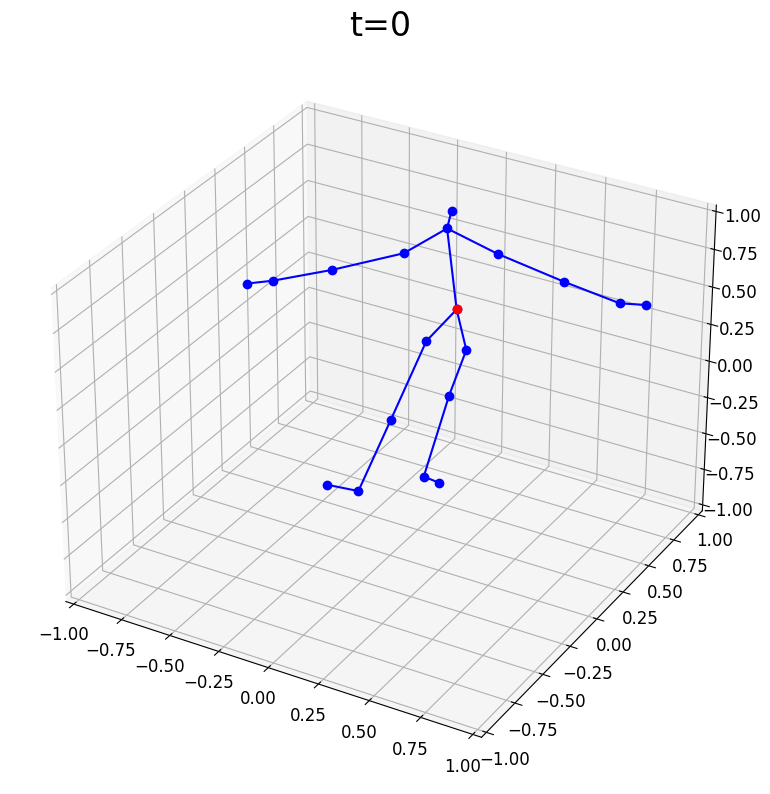

In [66]:
transform = torch.ones_like(pose0)/2
fig, ax = vis.plot_3d_pose(pose0- transform)
ax.plot((pose0-transform)[0][0],(pose0-transform)[0][2],(pose0-transform)[0][1],'o', color = 'red')
ax.set_title('t=0')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.savefig('t_0.pdf')

In [67]:
pose0[2]

tensor([-0.1002,  0.5975,  2.1230])

In [68]:
(pose1-transform)[2][1]

tensor(-0.0882)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18080\797637601.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


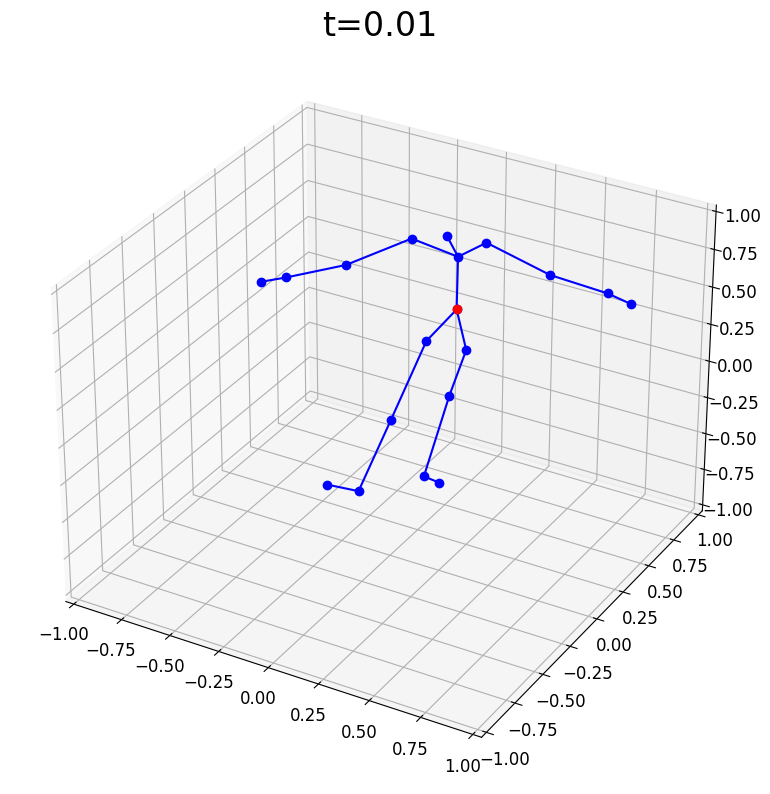

In [69]:
transform = torch.ones_like(pose0)/2
fig, ax = vis.plot_3d_pose(pose1- transform)
ax.plot((pose1-transform)[0][0],(pose1-transform)[0][2],(pose1-transform)[0][1],'o', color = 'red')
ax.set_title('t=0.01')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.savefig('t_001.pdf')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18080\892331299.py:6: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


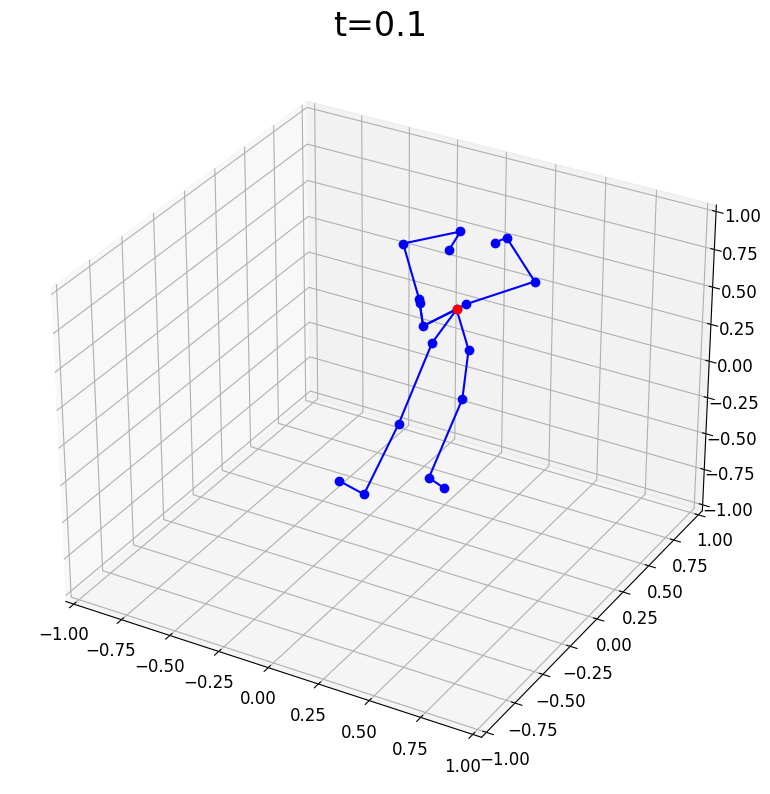

In [70]:
fig, ax =vis.plot_3d_pose(pose2- transform)
ax.plot((pose2-transform)[0][0],(pose2-transform)[0][2],(pose2-transform)[0][1],'o', color = 'red')
ax.set_title('t=0.1')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.savefig('t_01.pdf')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18080\765785610.py:6: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)


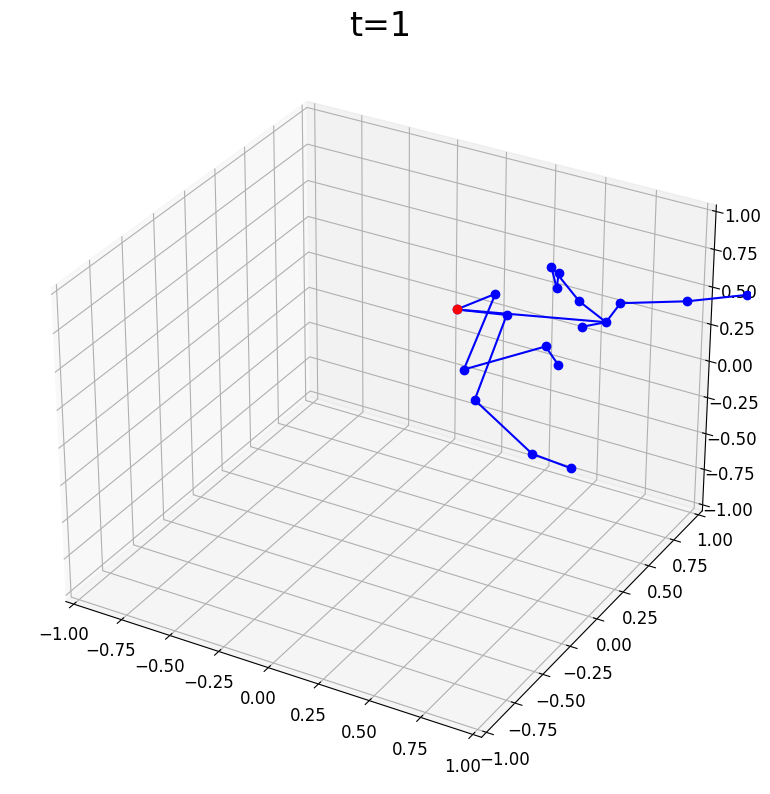

In [71]:
fig, ax =vis.plot_3d_pose(pose4- transform)
ax.plot((pose4-transform)[0][0],(pose4-transform)[0][2],(pose4-transform)[0][1],'o', color = 'red')
ax.set_title('t=1')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.savefig('t_100.pdf')

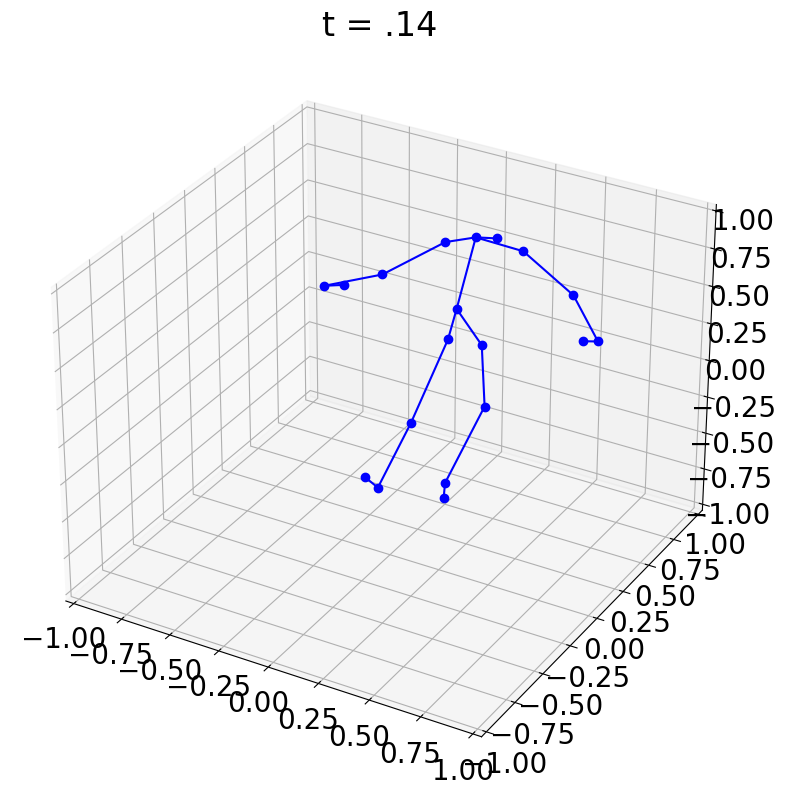

In [72]:
vis.plot_3d_pose(pose3- transform)
plt.title("t = .14")
plt.savefig('t_14.pdf')

## Geodesic Random Walk